# Imports
This cell imports standard Python libraries, reloads custom project modules (data, tools, plot) to ensure the latest changes are used, and sets default plotting parameters for Matplotlib (inline plotting, figure size, grid on axes).

In [5]:
# --- Imports standard libraries ---
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import importlib
import torch.nn.functional as F

# --- Imports project modules ---
import data
import tools
import plot
importlib.reload(data)
importlib.reload(tools)
importlib.reload(plot)

from tools import *      
from data import *
from plot import *

# --- Matplotlib settings ---
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.grid'] = True


# Visualizing Selected Channels for a Specific Subject and Trial
This cell selects a subject and trial, loads the corresponding metadata and signal, chooses a subset of channels (to_plot), and visualizes them using the show_plot_simple function.

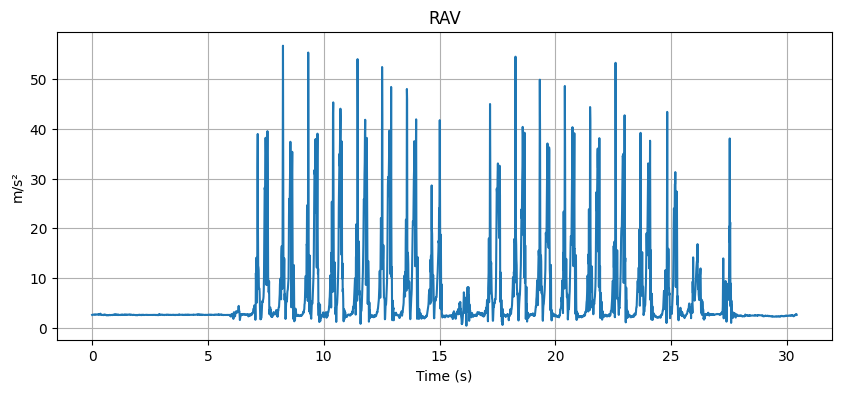

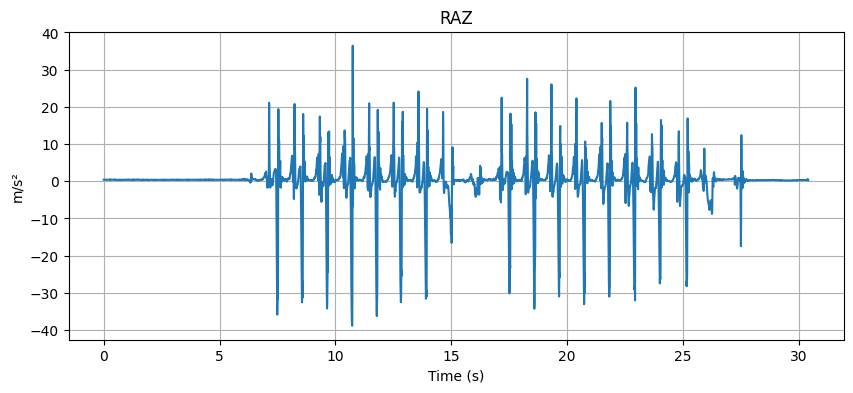

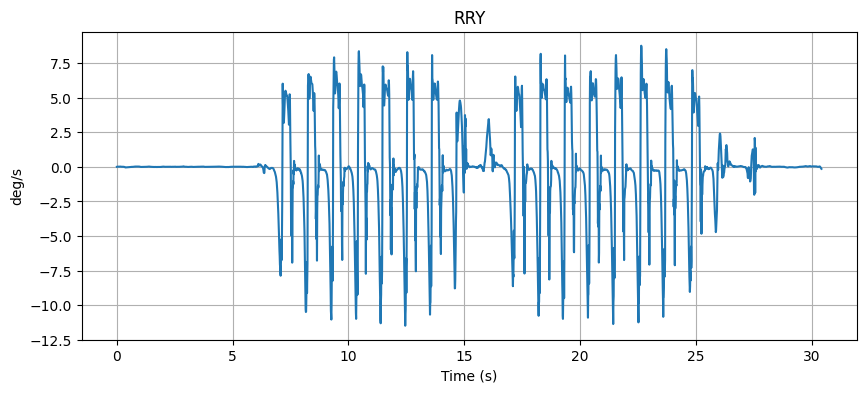

In [6]:
subject = 5
trial = 1
metadata = load_metadata(subject, trial)
signal = load_signal(subject, trial)

#to_plot = ['TOX','TAX','TAY','RAV','RAZ','RRY','LAV','LAZ','LRY']
to_plot = ['RAV','RAZ','RRY']
show_plot_simple(signal, to_plot)


# Building the Dataset and Running CDL on Selected Signals

### Constructing Data Tensor `X` and Running CDL

**Overview:**
This cell builds the input tensor $X$ for multiple subjects and selected signals, and applies **Convolutional Dictionary Learning (CDL)** to extract common atoms $\Phi$ and their sparse activations $Z$.

- **Inputs:**
  - $X \in \mathbb{R}^{S \times N \times P}$ — data tensor:
    - $S$ = number of subjects
    - $N$ = number of time samples per subject
    - $P$ = number of selected signals
  - `nb_atoms` = number of dictionary atoms $K$
  - `atoms_length` = length of each atom$ L $

- **Outputs:**
  - $\Phi \in \mathbb{R}^{K \times L \times P}$ — learned dictionary atoms
  - $Z \in \mathbb{R}^{S \times K \times (N-L+1)}$ — sparse activations
  - $A \in \mathbb{R}^{S \times K \times M}$ — **Personalized Parameters** (e.g., time warping coefficients).
---
**Steps and Details:**

- **Initialization:**
  $$\Phi, A, Z \gets \text{setInitialValues}(X, K, M, L)$$
  - Provides initial estimates for the dictionary and activations.

- **Main CDL Loop:**
    - Iteratively update activations $Z$ and atoms $\Phi$:

    1. Sparse Coding Step (CSC-L0) implemented via **`CSC_L0_DP(X, Z, Phi, lambda_)`**:
       $$
       Z \gets \text{CSC}(X, Z,\Phi): \text{for any } s \in [S], \ \arg \min_{Z_s \geq 0} \left\| x_s - \sum_{k=1}^K z_{k}^s * \phi_k \right\|_2^2 + \lambda ||Z||_0
       $$
    2. Dictionary Update (CDU) implemented via **`CDU(X, Z, Phi, lr)`**:
       $$
       \Phi \gets \text{CDU}(X, Z,\Phi): \ \arg \min_{\|\phi_k\|_2 = 1} \sum_{s=1}^S \left\| x_s - \sum_{k=1}^K z_{k}^s * \phi_k \right\|_2^2
       $$

In [7]:
subjects = list(range(1, 11))  # 10 subjects
signal_names = ['RAV','RAZ','RRY']  
X = build_X(subjects, signal_names, trial=1)

#### Signal Filtering


--- PSD and Cutoff Frequencies for Subject 2 ---


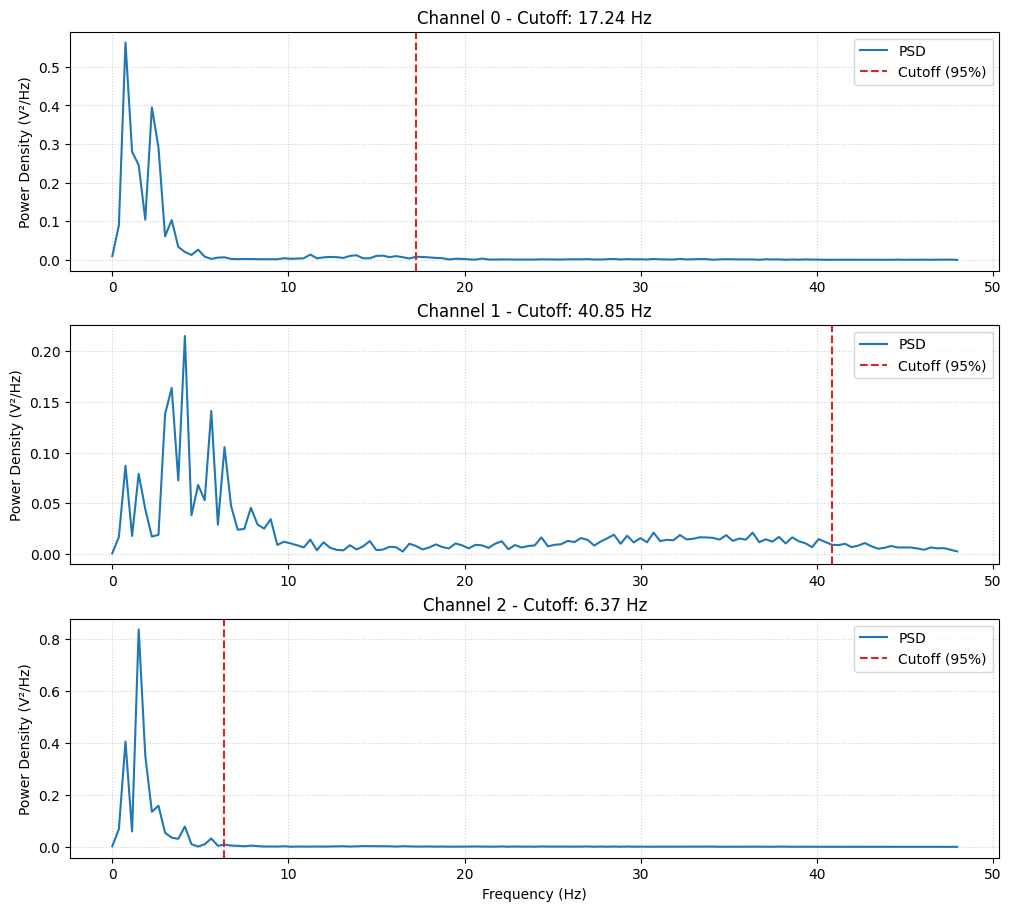

Recommended Cutoffs: [[34.10722656 43.47734375  9.37011719]
 [31.85839844 28.85996094  5.24726562]
 [17.24101562 40.85371094  6.37167969]
 [37.10566406 31.85839844  8.24570313]
 [23.23789063 28.48515625  8.24570313]
 [28.85996094 25.11191406 20.61425781]
 [34.10722656 32.23320313  5.996875  ]
 [31.85839844 39.35449219 25.48671875]
 [29.60957031 34.48203125 14.61738281]
 [37.10566406 33.35761719  5.24726562]] 


In [4]:

fs = 95.95
best_cutoff = find_optimal_cutoff(X, fs=fs, percentile=0.95, subject=2)
print(f"Recommended Cutoffs: {best_cutoff} ")

# Apply these single numbers to your filter function

X_filtered = apply_low_pass(X, best_cutoff, fs=fs,order=3)

Channel RAV - Original vs Filtered Cutoff: [34.10722656 43.47734375  9.37011719] Hz


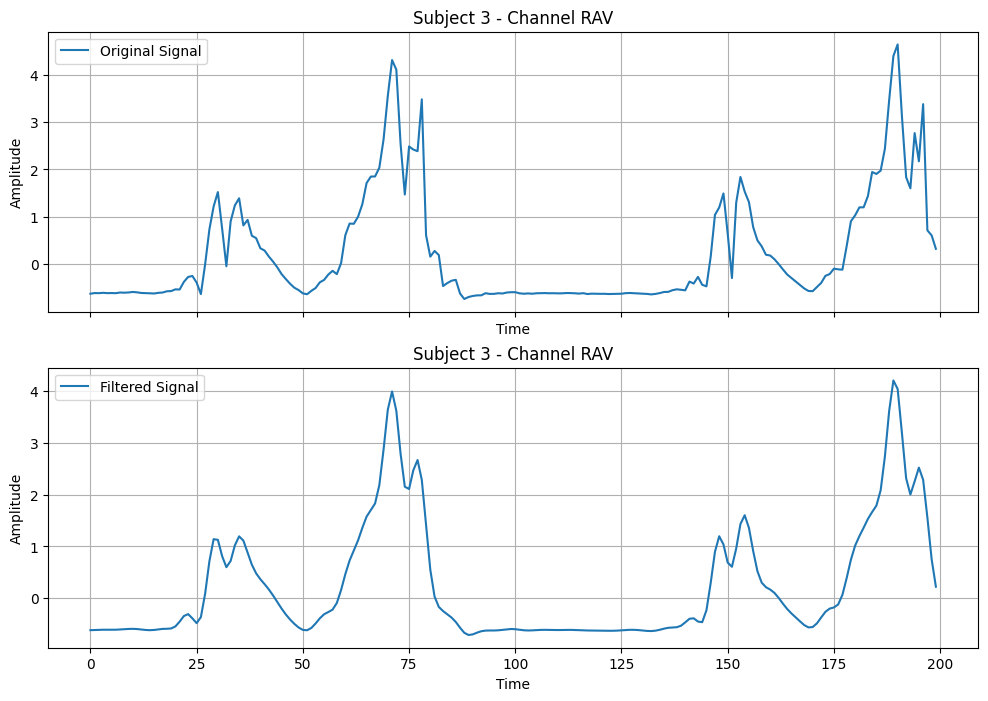

Channel RAZ - Original vs Filtered Cutoff: [31.85839844 28.85996094  5.24726562] Hz


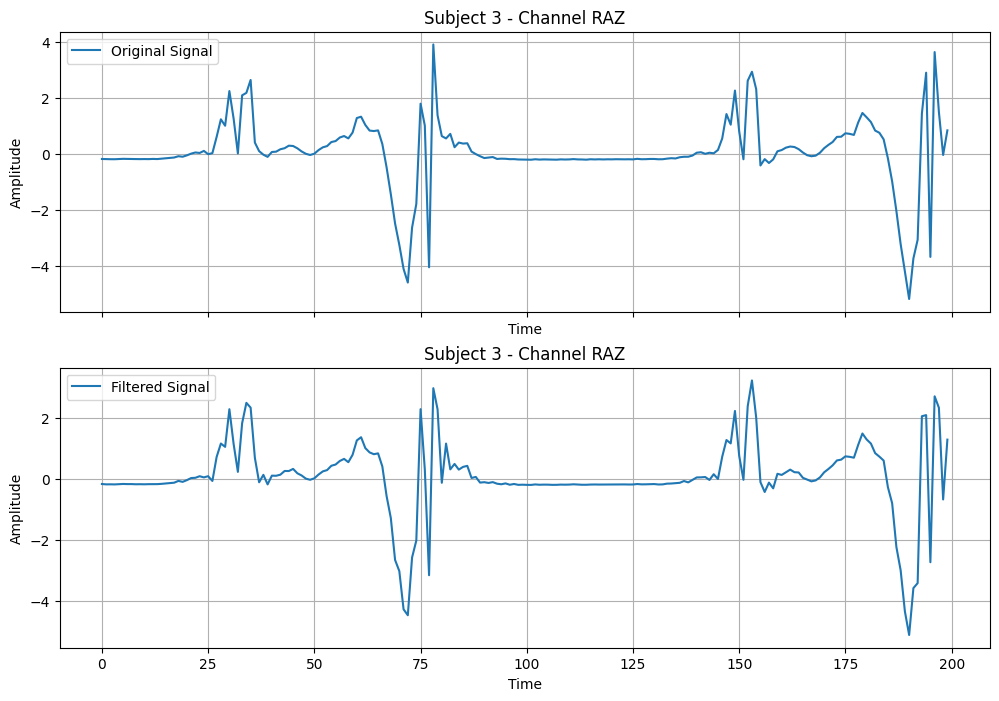

Channel RRY - Original vs Filtered Cutoff: [17.24101562 40.85371094  6.37167969] Hz


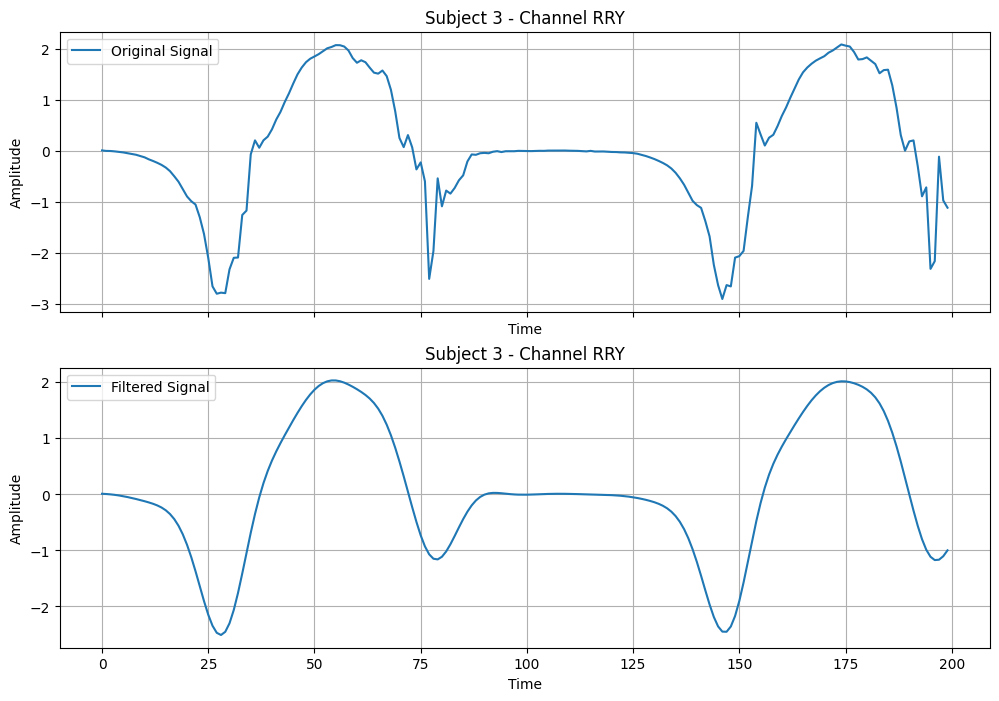

In [5]:
subject = 2

for channel in range(X.shape[2]):
    print(f"Channel {signal_names[channel]} - Original vs Filtered Cutoff: {best_cutoff[channel]} Hz")

    fig,ax = plt.subplots(2,1, figsize=(12,8), sharex=True)

    ax[0].plot(X[subject, 400:600, channel], label='Original Signal')
    ax[0].set_title(f'Subject {subject + 1} - Channel {signal_names[channel]}')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Amplitude')
    ax[0].legend()
    ax[1].plot(X_filtered[subject, 400:600, channel], label='Filtered Signal')
    ax[1].set_title(f'Subject {subject + 1} - Channel {signal_names[channel]}')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Amplitude')
    ax[1].legend()
    plt.show()

In [6]:
Z,Phi,A=CDL(X,nb_atoms=2,lambda_=0.01,n_iters=30,signal_names=signal_names)

In [7]:
## Filtered Signal
X_filtered = torch.tensor(X_filtered, dtype=torch.float32)
Zf,Phif,Af=CDL(X_filtered,nb_atoms=2,lambda_=0.01,n_iters=30,signal_names=signal_names)

# Post-CDL Analysis: Visualization and Metrics

After the **CDL** (Convolutional Dictionary Learning) training phase, the function `full_plot_analysis(X, Z, Phi)` is used to evaluate and interpret the results. This cell executes a series of visualizations and metric calculations to provide a comprehensive overview of the learned dictionary ($\Phi$) and the quality of the reconstruction.

The function sequentially calls several sub-routines to analyze the outputs:

* **1. `plot_atoms(Phi)`**
    * **Description:** **Visualization of Atoms** ($\Phi$).
    * **Role:** Displays each learned atom across its different channels ($P$). It helps in understanding the **common temporal patterns** extracted from the data.

* **2. `plot_reconstruction(X, Z, Phi)`**
    * **Description:** **Signal Reconstruction**.
    * **Role:** Compares the **original signal** ($X$) with the **reconstructed signal** (calculated from $Z * \Phi$). Areas of atom activation are indicated by **colored bars**.

* **3. `plot_activations(Z)`**
    * **Description:** **Visualization of Activations** ($Z$).
    * **Role:** Displays the time series of the **sparse activation coefficients** for each atom for a given subject. It shows *when* and *where* each pattern was detected.

* **4. `print_metrics(X, Z, Phi)`**
    * **Description:** **Global Metrics**.
    * **Role:** Displays the **L2 norm** of the atoms (should be close to 1) and calculates the global **MSE** (Mean Squared Error) between the original and the reconstructed signals.

This analysis confirms that the atoms are well-formed, the reconstruction is accurate, and the activations correspond to relevant events over time.

--- Displaying Atoms (Phi) ---


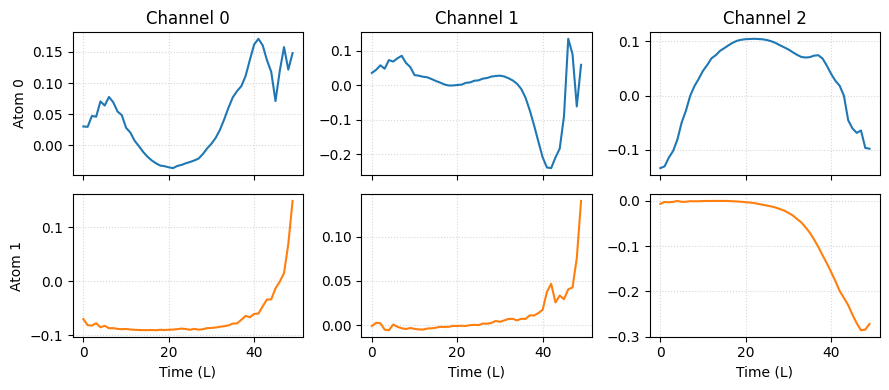


--- Reconstruction and MSE per Subject ---


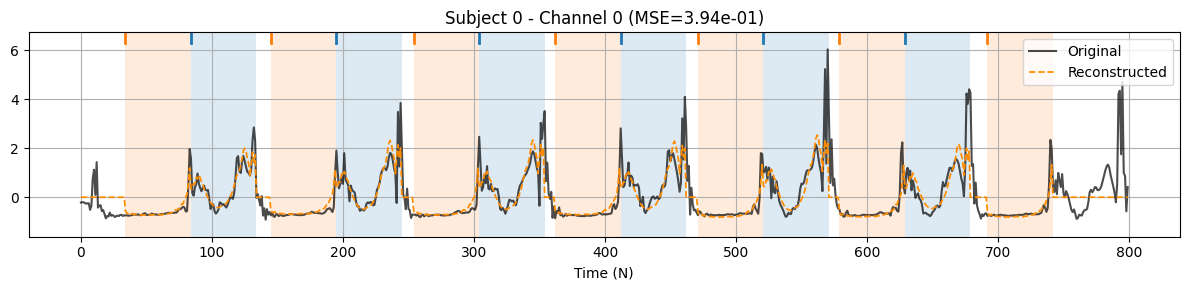

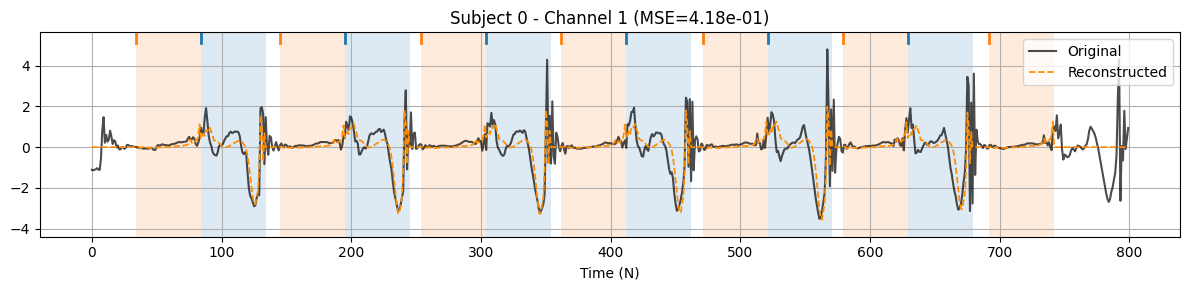

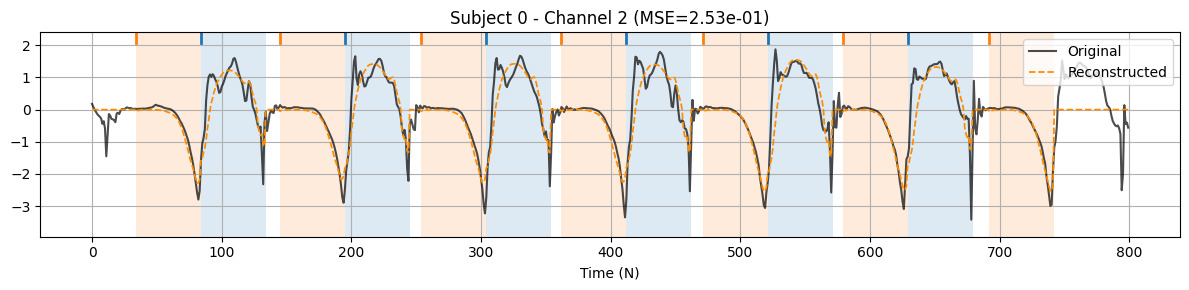


--- Displaying Activations (Z) ---


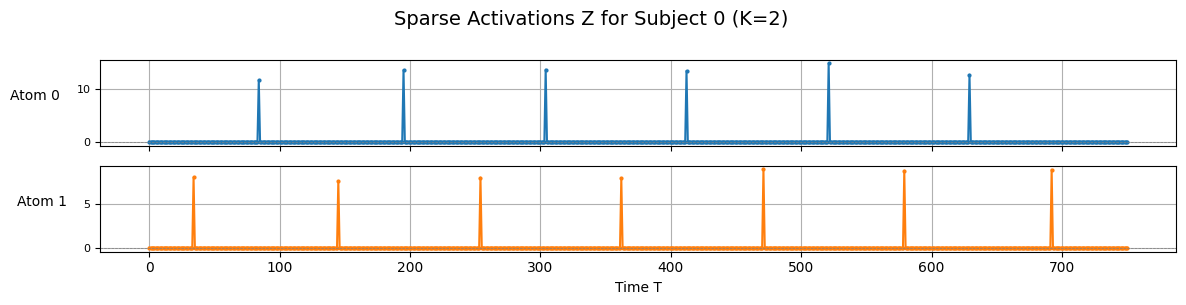


--- Global Statistics ---
MSE Mean: 3.774387e-01 | Std: 7.668687e-02
MSE Min : 2.798594e-01 | Max: 5.448652e-01
Sparsity Rate (>1e-9): 0.7923%
Avg active coefficients per subject: 11.90


In [8]:
full_plot_analysis(X,Z,Phi)

--- Displaying Atoms (Phi) ---


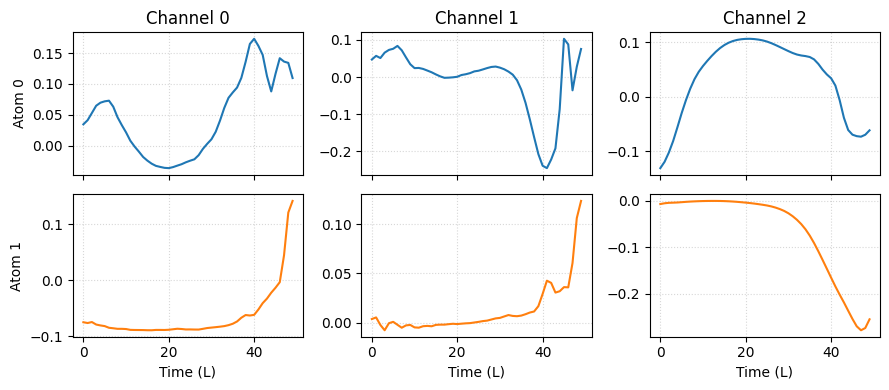


--- Reconstruction and MSE per Subject ---


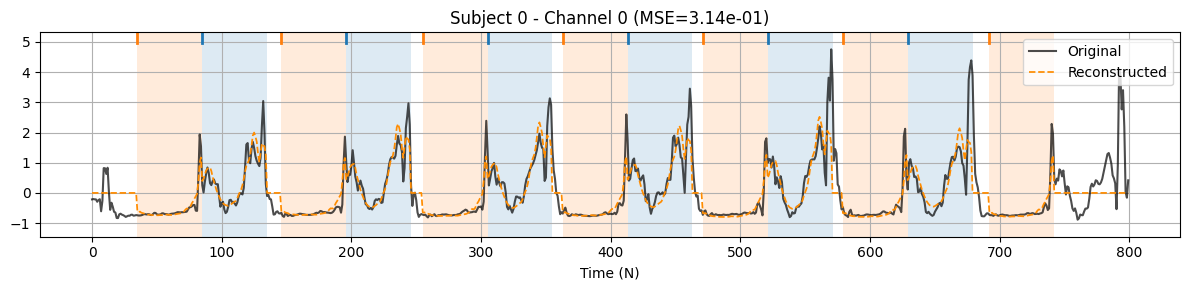

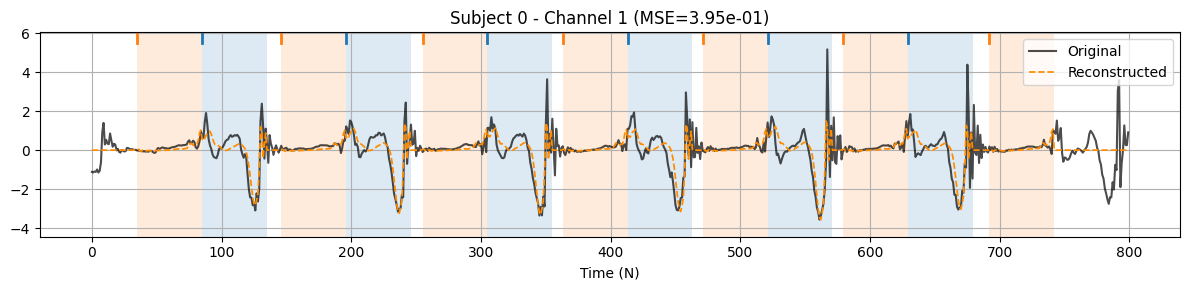

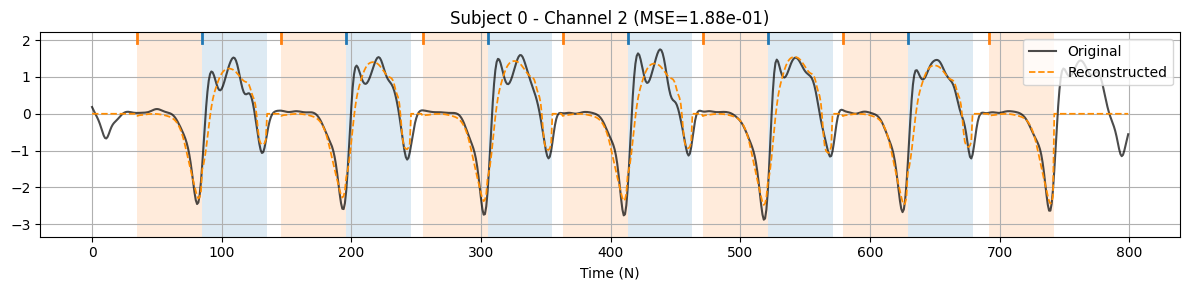


--- Displaying Activations (Z) ---


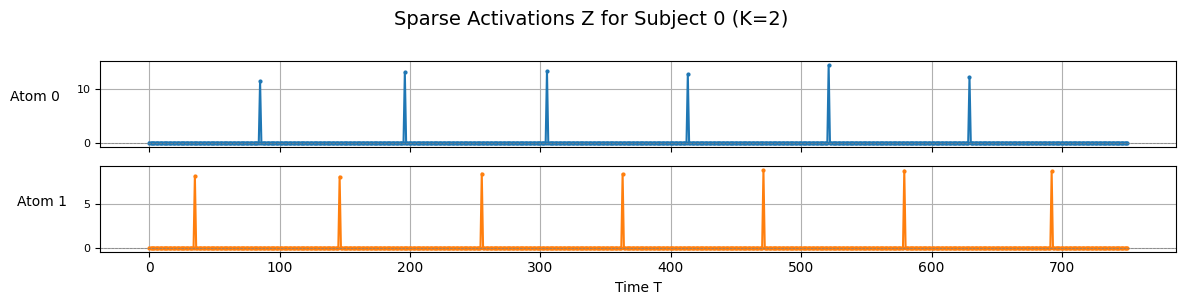


--- Global Statistics ---
MSE Mean: 3.153516e-01 | Std: 7.398523e-02
MSE Min : 2.325909e-01 | Max: 4.748654e-01
Sparsity Rate (>1e-9): 0.7989%
Avg active coefficients per subject: 12.00


In [9]:
## Filtered Signal
full_plot_analysis(X_filtered,Zf,Phif)

# Personalized Convolutional Dictionary Learning (PerCDL)

### Running PerCDL and Extracting Personalized Parameters

**Overview:**
This cell executes the **Personalized Convolutional Dictionary Learning (PerCDL)** algorithm. PerCDL first finds a set of common atoms $\Phi$ (standard CDL phase) and then refines the model by introducing **personalized parameters** $A$ to account for subject-specific variations (e.g., time warping).

- **Inputs:**
  - $X \in \mathbb{R}^{S \times N \times P}$ — data tensor (S subjects, N samples, P signals).
  - `nb_atoms` = number of dictionary atoms $K$.
  - `atoms_length` = length of each atom $L$.
  - $\lambda$ = sparsity regularization parameter.
  - $D, W$ = parameters defining the personalized space $A$.
  - `func` = Time Warping function
  - `nb_iters` = number of iterations of the main CDL Loop.
  - `nb_perso` = number of iterations of the Personalization Loop

- **Outputs:**
  - $A \in \mathbb{R}^{S \times K \times M}$ — **Personalized Parameters** (e.g., time warping coefficients).
  - $Z \in \mathbb{R}^{S \times K \times (N-L+1)}$ — sparse activations.
  - $\Phi \in \mathbb{R}^{K \times L \times P}$ — learned dictionary atoms.

---
**Steps and Details**

- **Initialization:**
  $$
  \Phi, Z, A \gets \text{setInitialValues}(X, K, M, L)
  $$
  - Provides initial estimates for the dictionary $\Phi$, activations $Z$, and personalized parameters $A$.

- **Main CDL Loop (Shared Dictionary Learning)**        
Run for `n_iters` iterations.
    1. Sparse Coding Step (CSC-L0-DP):
       $$Z \gets \text{CSC}(X, Z, \Phi)$$
    2. Dictionary Update (CDU):
       $$
       \Phi \gets \text{CDU}(X, Z, \Phi)
       $$

- **Personalization Loop (PerCDL Refinement)**    
Run for `n_perso` iterations.
    1. Individual Parameter Update (IPU):
       $$
       A \gets \text{IPU}(X, Z, \Phi, A, f)
       $$
       - Updates the personalized parameters $A$ (e.g., warping coefficients) for each subject based on the current $\Phi$ and $Z$.

    2. Sparse Coding Step (CSC-L0-DP):
       $$
       Z \gets \text{CSC}(X, Z, \Phi, \lambda)
       $$
       - Recomputes activations $Z$.

    3. Personalized Dictionary Update (PerCDU):
       $$
       \Phi \gets \text{PerCDU}(X, Z, \Phi, A, f)
       $$
       - Updates the dictionary $\Phi$ by accounting for the personalized parameters $A$.

In [10]:
a,z,phi = Personalization(X,A,Z,Phi,lambda_=0.01,n_perso=30)

In [11]:
# Filtered version
af,zf,phif = Personalization(X_filtered,Af,Zf,Phif,lambda_=0.01,n_perso=30)

# Post-PerCDL Analysis: Visualization and Metrics

--- Displaying Atoms (Phi) ---


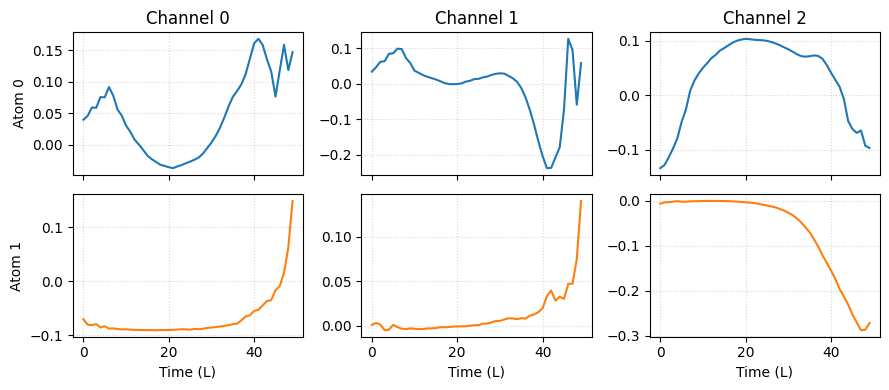


--- Reconstruction and MSE per Subject ---


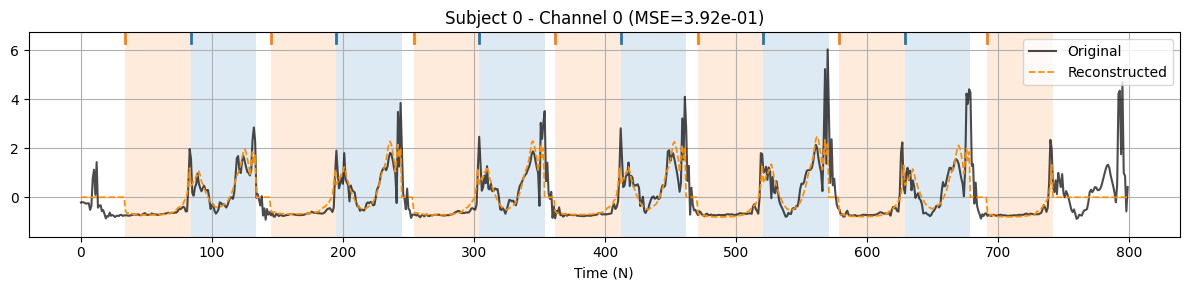

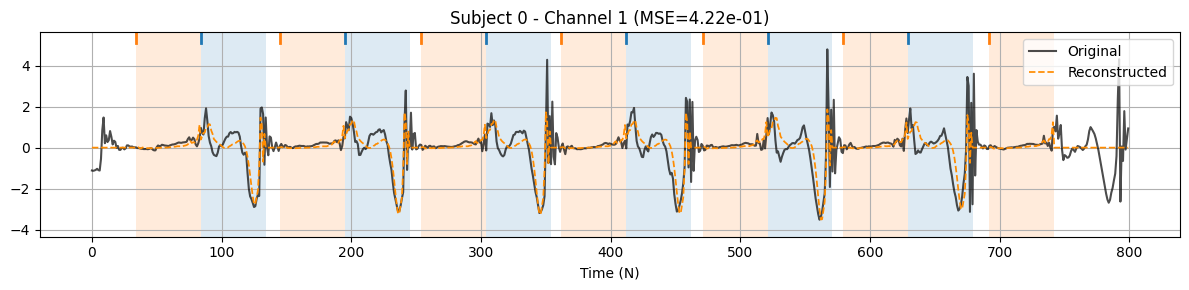

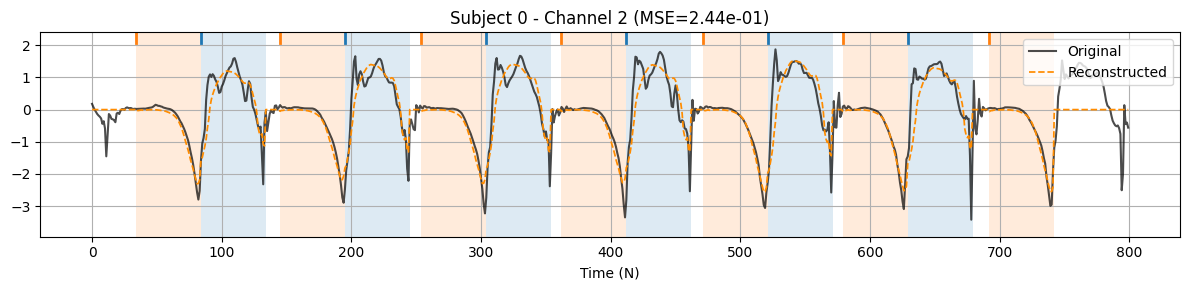


--- Displaying Activations (Z) ---


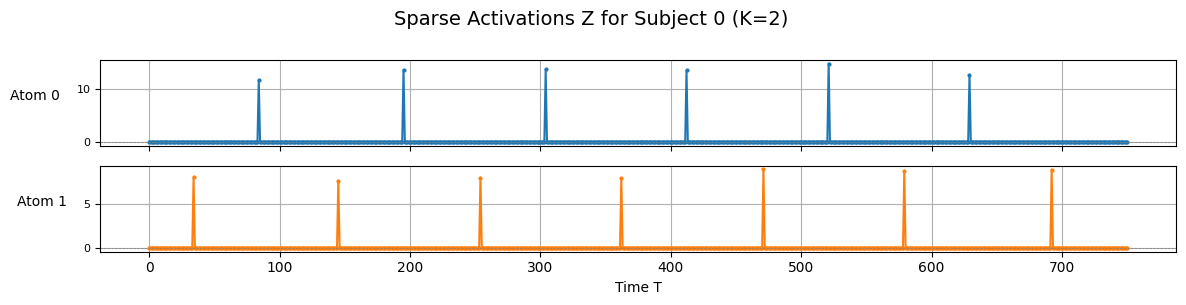


--- Global Statistics ---
MSE Mean: 3.792273e-01 | Std: 7.843339e-02
MSE Min : 2.853892e-01 | Max: 5.469267e-01
Sparsity Rate (>1e-9): 0.7923%
Avg active coefficients per subject: 11.90


In [12]:
full_plot_analysis(X,z,phi)

--- Displaying Atoms (Phi) ---


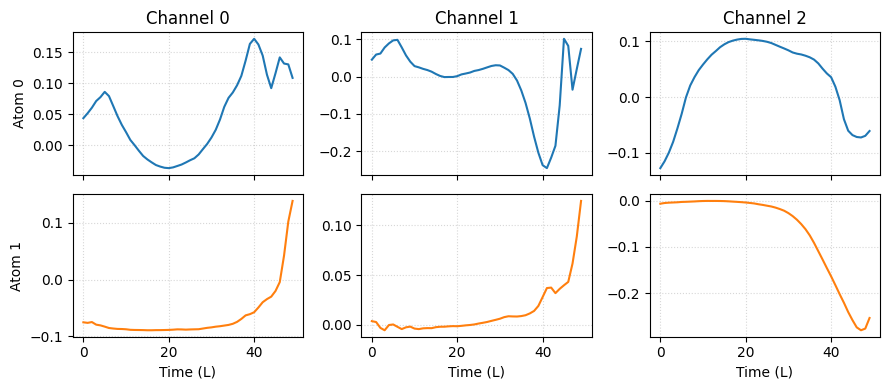


--- Reconstruction and MSE per Subject ---


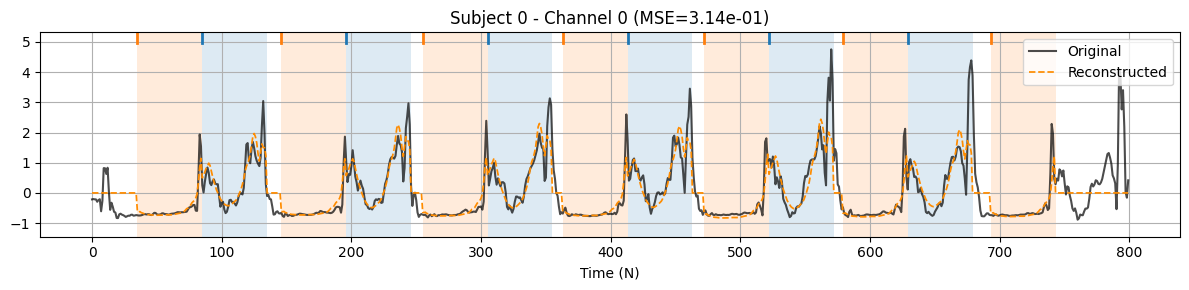

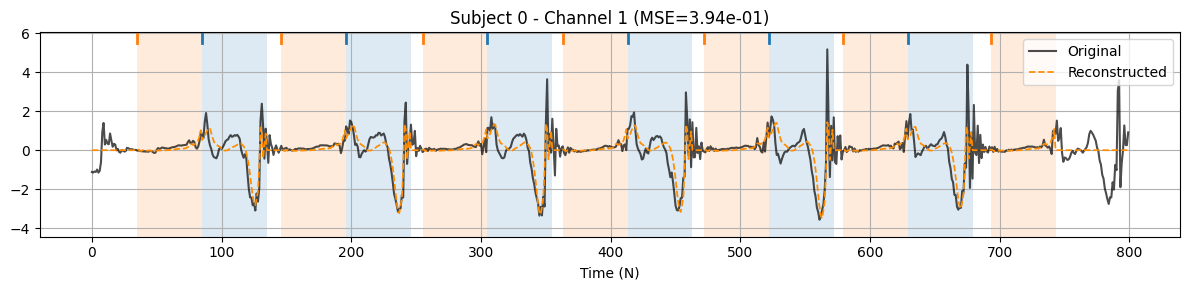

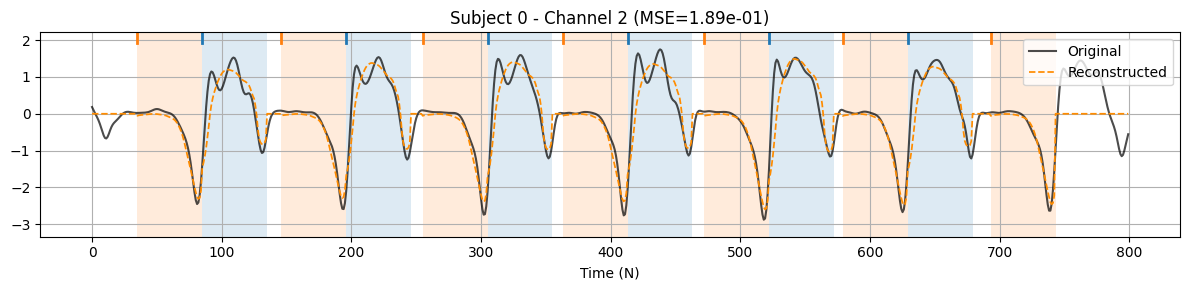


--- Displaying Activations (Z) ---


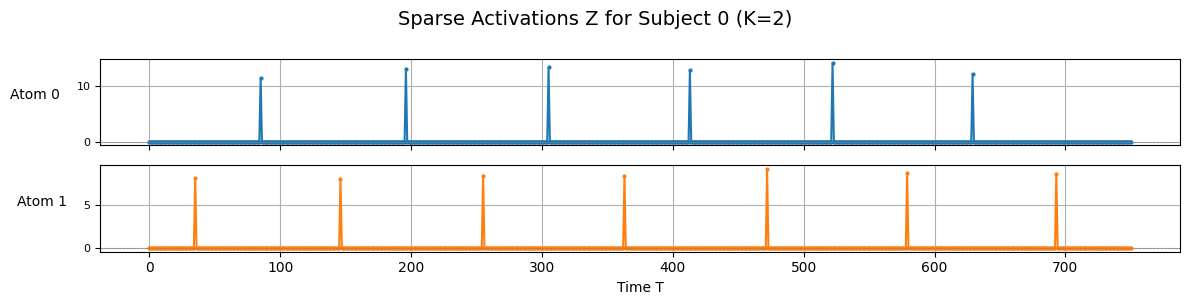


--- Global Statistics ---
MSE Mean: 3.162790e-01 | Std: 7.543116e-02
MSE Min : 2.283131e-01 | Max: 4.762095e-01
Sparsity Rate (>1e-9): 0.7989%
Avg active coefficients per subject: 12.00


In [13]:
## Filtered version
full_plot_analysis(X_filtered,zf,phif)


  FULL TIME-WARPING ANALYSIS - Subject 0/10

 Global MSE (General): 3.5264e-01
 Global MSE (Warped) : 3.0252e-01
 Improvement Gain    : 14.21%

--- Warped Reconstruction Visualization (Subject 0) ---


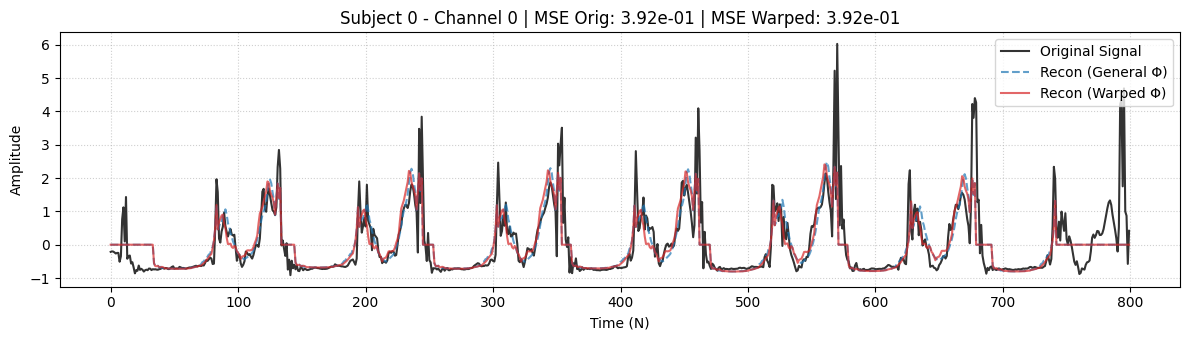

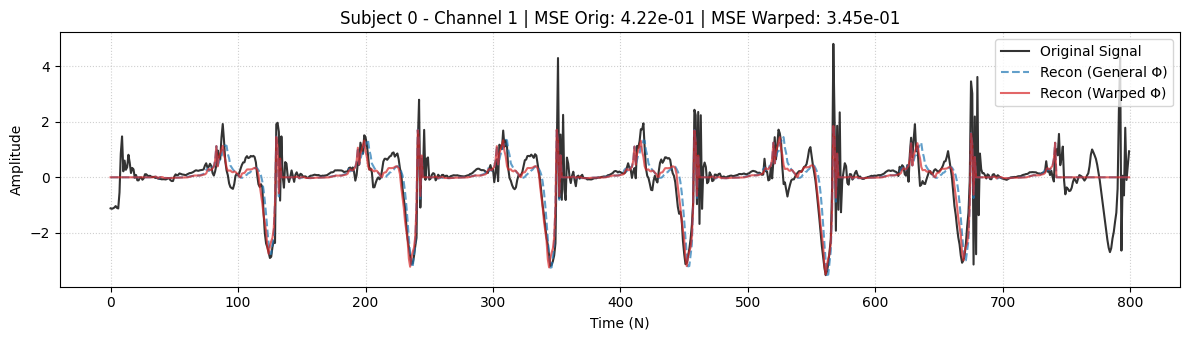

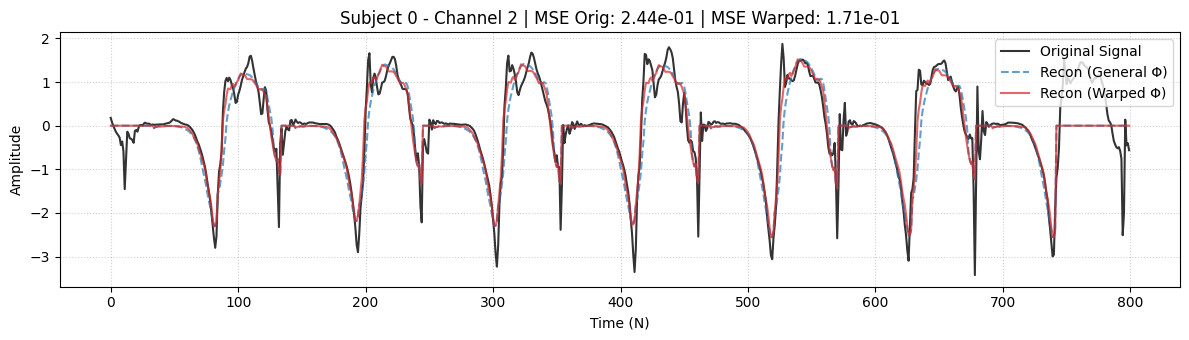


--- MSE Comparison (Subject 0) ---


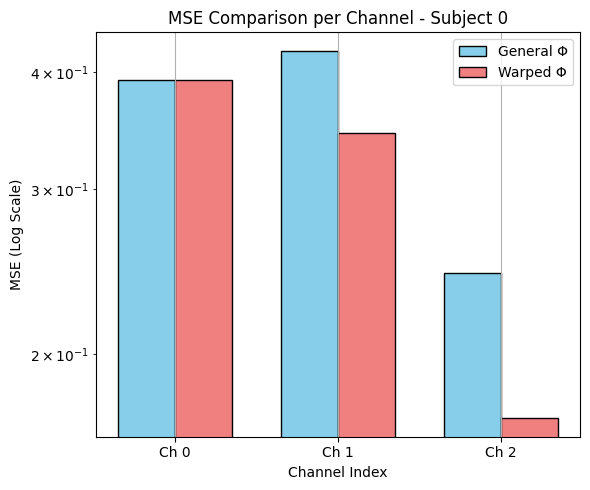


--- General vs. Personalized Atoms (Subject 0) ---


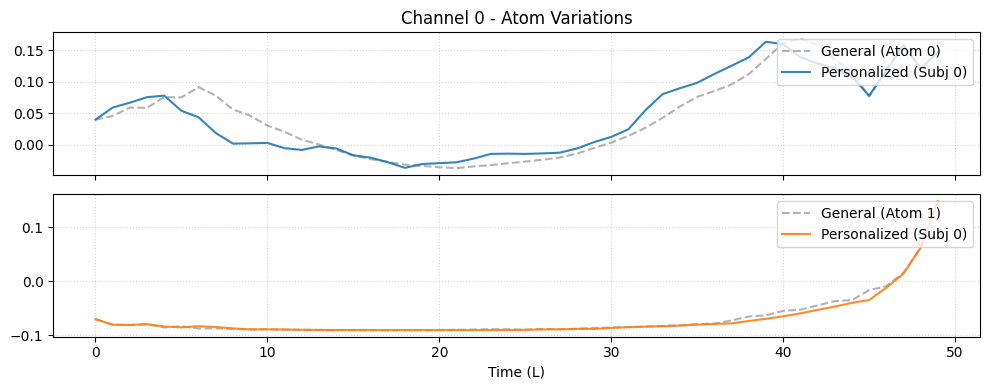

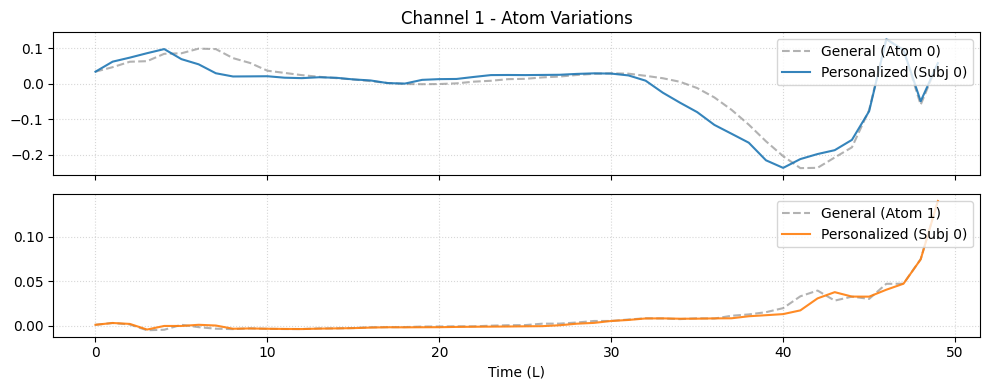

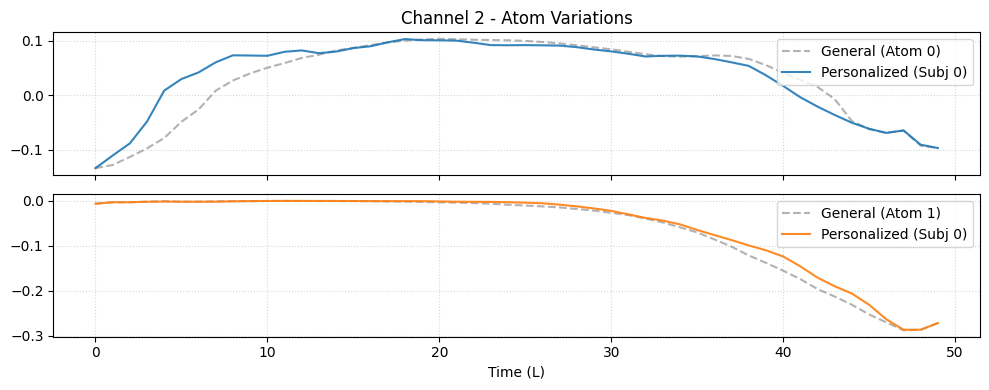

In [14]:
full_warping_analysis(X,z,phi,a)


  FULL TIME-WARPING ANALYSIS - Subject 0/10

 Global MSE (General): 2.9904e-01
 Global MSE (Warped) : 2.4998e-01
 Improvement Gain    : 16.41%

--- Warped Reconstruction Visualization (Subject 0) ---


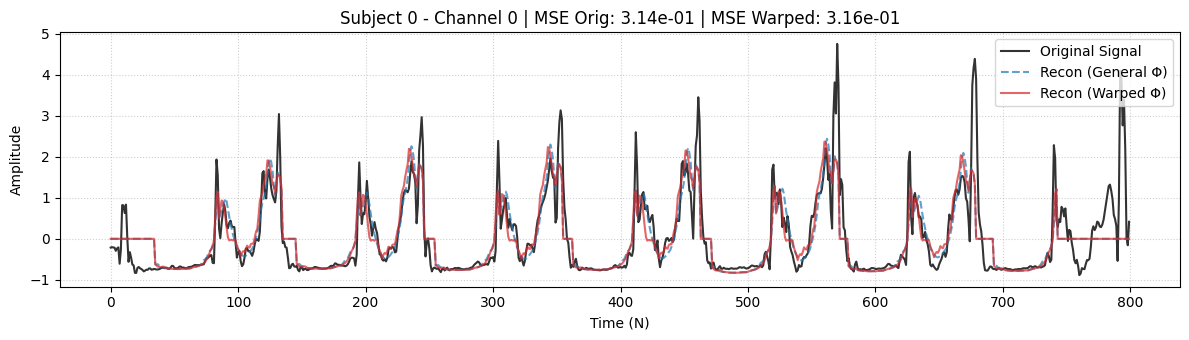

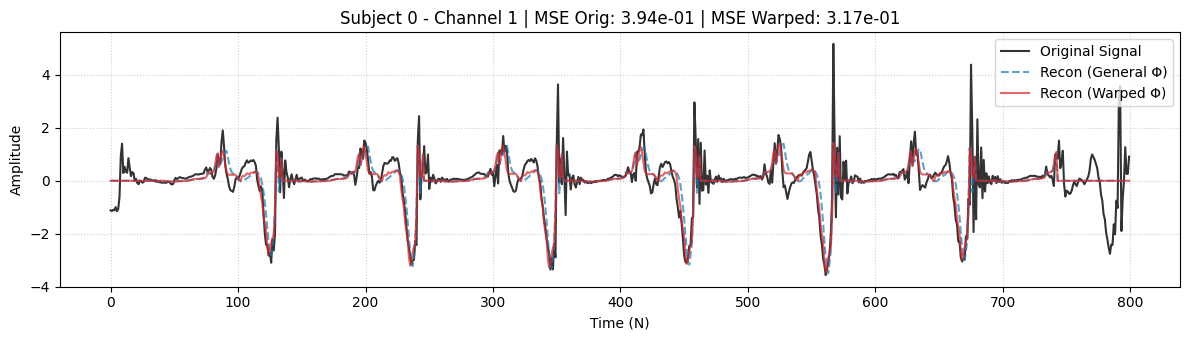

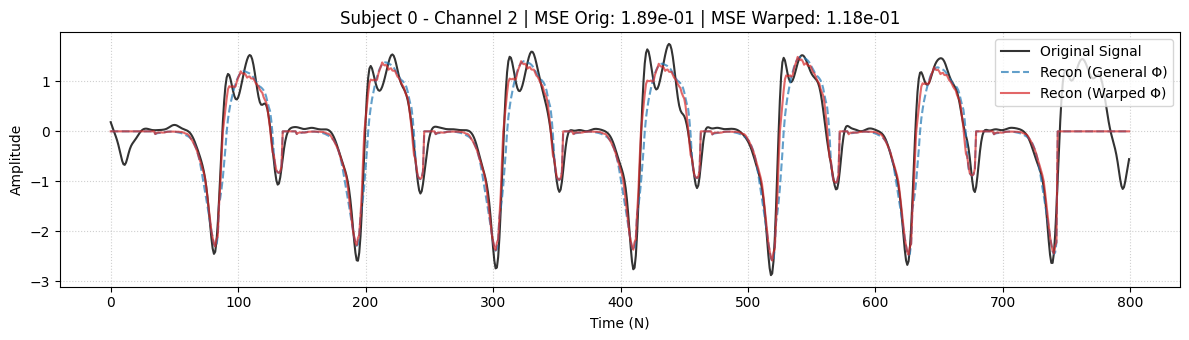


--- MSE Comparison (Subject 0) ---


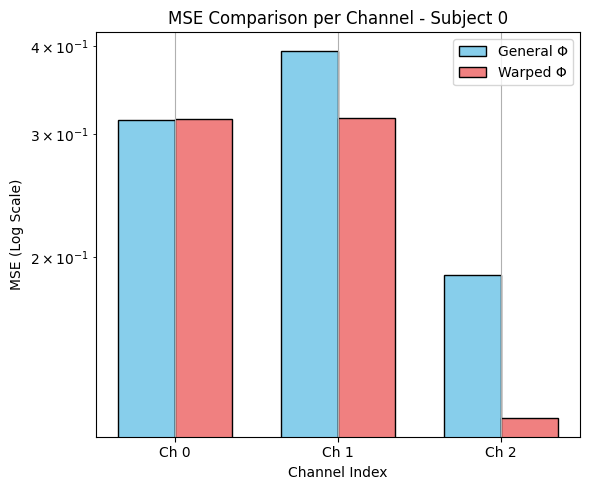


--- General vs. Personalized Atoms (Subject 0) ---


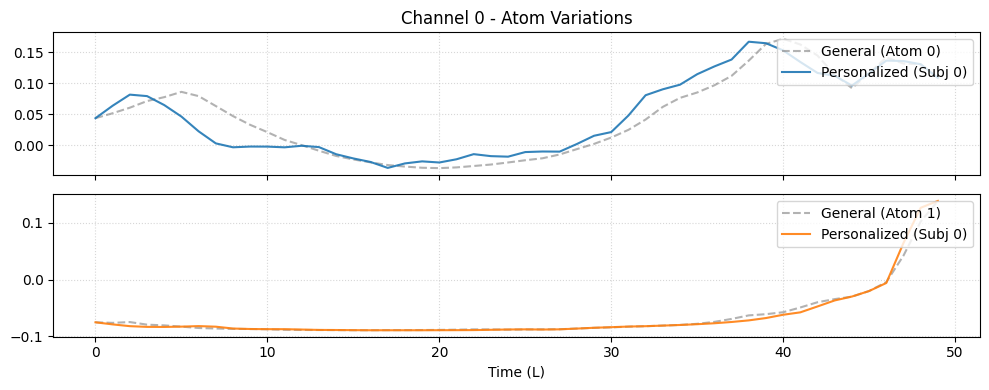

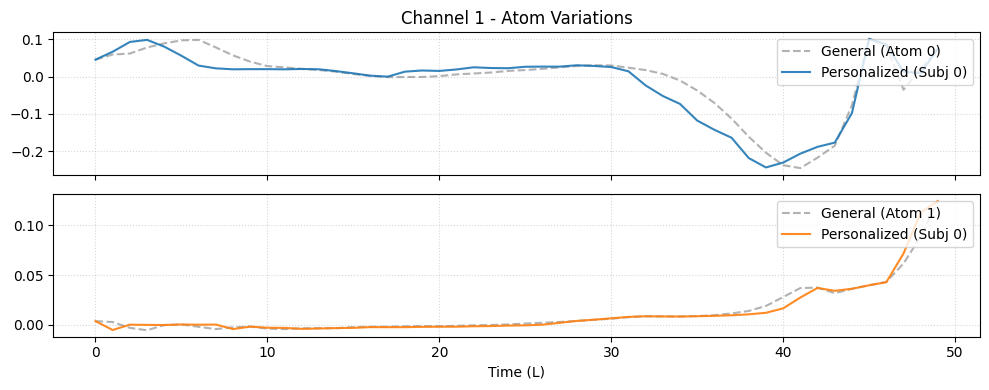

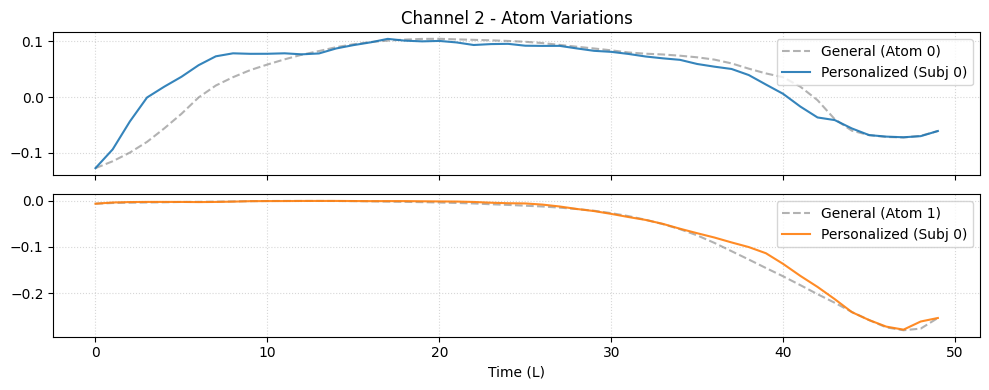

In [15]:
## Filtered version
full_warping_analysis(X_filtered,zf,phif,af)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def plot_method_comparison(X, Z_per, Phi_per, A_per, Z_cdl, Phi_cdl, time_warping_f):
    """
    Compares the mean MSE (over all subjects) per channel between:
    1. CDL (Standard)
    2. PerCDL (Personalized with Time Warping)
    
    Args:
        X: (S, N, P) Original signal
        Z_per: (S, K, T) PerCDL Activations
        Phi_per: (K, L, P) PerCDL Atoms
        A_per: (S, K) Warping parameters
        Z_cdl: (S, K, T) CDL Activations
        Phi_cdl: (K, L, P) CDL Atoms
        time_warping_f: Differentiable warping function
    """
    
    # 1. Verification and Device
    device = X.device
    S, N, P = X.shape
    
    # Ensure everything is on the same device for calculations
    Z_per, Phi_per, A_per = Z_per.to(device), Phi_per.to(device), A_per.to(device)
    Z_cdl, Phi_cdl = Z_cdl.to(device), Phi_cdl.to(device)

    print(f"--- Comparison CDL vs PerCDL (S={S} subjects, P={P} channels) ---")

    # ==========================================
    # 2. MSE Calculation for CDL (Batch Processing)
    # ==========================================
    # Phi shape for conv: (K, P, L)
    phi_cdl_conv = Phi_cdl.permute(0, 2, 1)
    
    # Batched reconstruction: (S, P, N_recon)
    # Z_cdl is (S, K, T), output is (S, P, length)
    recon_cdl = F.conv_transpose1d(Z_cdl, phi_cdl_conv)
    
    # Transpose to match X: (S, length, P)
    recon_cdl = recon_cdl.permute(0, 2, 1)
    
    # Crop if reconstruction exceeds N
    if recon_cdl.shape[1] > N:
        recon_cdl = recon_cdl[:, :N, :]
    
    # Calculate MSE per channel (mean over S and N)
    # (X - Recon)^2 -> mean over dim 0 (S) and 1 (N) -> remains dim 2 (P)
    mse_cdl_per_channel = torch.mean((X - recon_cdl) ** 2, dim=(0, 1)).detach().cpu().numpy()

    # ==========================================
    # 3. MSE Calculation for PerCDL (Subject Loop)
    # ==========================================
    # Cannot batch easily because Phi changes for every subject (Warping)
    
    mse_per_accumulator = torch.zeros(P, device=device)
    K = Phi_per.shape[0]

    for s in range(S):
        z_s = Z_per[s].unsqueeze(0) # (1, K, T)
        
        # Construction of warped dictionary for subject s
        warped_phis_list = []
        for k in range(K):
            # Warp atom k with parameter alpha for subject s
            phi_k = Phi_per[k]       # (L, P)
            alpha_k_s = A_per[s, k]  # Scalar
            
            w_phi = time_warping_f(phi_k, alpha_k_s) # (L, P)
            warped_phis_list.append(w_phi.unsqueeze(0))
            
        # Concatenation and permutation for conv
        Phi_s = torch.cat(warped_phis_list, dim=0) # (K, L, P)
        phi_s_conv = Phi_s.permute(0, 2, 1)        # (K, P, L)
        
        # Reconstruction for subject s
        recon_s = F.conv_transpose1d(z_s, phi_s_conv).permute(0, 2, 1) # (1, len, P)
        
        # Crop
        if recon_s.shape[1] > N:
            recon_s = recon_s[:, :N, :]
            
        # Mean squared error over time (N) for this subject
        # X[s] is (N, P), recon_s is (1, N, P)
        error_s = torch.mean((X[s].unsqueeze(0) - recon_s) ** 2, dim=1).squeeze(0) # (P,)
        
        mse_per_accumulator += error_s

    # Mean over subjects
    mse_per_per_channel = (mse_per_accumulator / S).detach().cpu().numpy()

    # ==========================================
    # 4. Plotting
    # ==========================================
    
    # Plot parameters
    x = np.arange(P)
    width = 0.35  # Bar width
    
    fig, ax = plt.subplots(figsize=(max(8, P * 1.5), 6))
    
    # Create bars
    rects1 = ax.bar(x - width/2, mse_cdl_per_channel, width, label='CDL (Standard)', color='skyblue', edgecolor='black', alpha=0.8)
    rects2 = ax.bar(x + width/2, mse_per_per_channel, width, label='PerCDL (Warped)', color='salmon', edgecolor='black', alpha=0.8)
    
    # Labels and Titles
    ax.set_xlabel('Channels (P)')
    ax.set_ylabel('Mean Squared Error (MSE)')
    ax.set_title(f'Average MSE Comparison per Channel (Over {S} patients)')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Ch {p}' for p in range(P)])
    ax.legend()
    
    # Add grid for readability
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # (Optional) Log scale if differences are large
    # ax.set_yscale('log') 

    # Add percentage gain above PerCDL bars
    for i in range(P):
        cdl_val = mse_cdl_per_channel[i]
        per_val = mse_per_per_channel[i]
        if cdl_val > 0:
            gain = (cdl_val - per_val) / cdl_val * 100
            ax.text(i + width/2, per_val, f'-{gain:.1f}%', 
                    ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkred')

    plt.tight_layout()
    plt.show()

    # Brief summary print
    print(f"Global MSE CDL    : {np.mean(mse_cdl_per_channel):.4e}")
    print(f"Global MSE PerCDL : {np.mean(mse_per_per_channel):.4e}")
    print(f"Overall Gain      : {(np.mean(mse_cdl_per_channel) - np.mean(mse_per_per_channel)) / np.mean(mse_cdl_per_channel) * 100:.2f}%")

In [9]:
subjects = list(range(1, 20))  # 10 subjects
signal_names = ['RAV']
X = build_X(subjects, signal_names, trial=1)
fs = 95.95
best_cutoff = find_optimal_cutoff(X, fs=fs, percentile=0.95)
X_filtered = apply_low_pass(X, best_cutoff, fs=fs,order=3)

X_filtered = torch.tensor(X_filtered, dtype=torch.float32)


In [ ]:
n_iters=30
n_perso=30
Zf,Phif,Af=CDL(X_filtered,nb_atoms=2,lambda_=0.01,n_iters=n_iters*2,signal_names=signal_names)
af,zf,phif = PerCDL(X_filtered,2,n_iters=n_iters,n_perso=n_perso,signal_names=signal_names)

--- Comparison CDL vs PerCDL (S=19 subjects, P=9 channels) ---


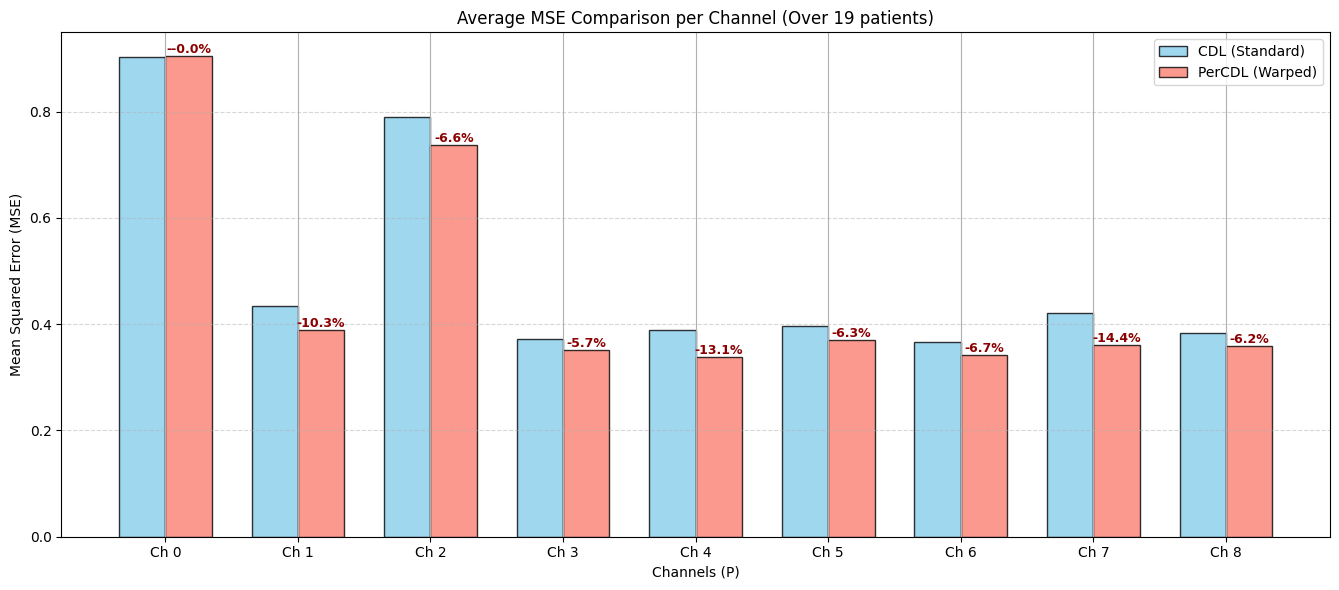

Global MSE CDL    : 4.9489e-01
Global MSE PerCDL : 4.6128e-01
Overall Gain      : 6.79%


In [23]:
plot_method_comparison(X_filtered, zf, phif, af, Zf, Phif, time_warping_f)

In [1]:
from percdl_federated.__init__ import *

In [10]:
X.shape

torch.Size([19, 800, 1])

In [11]:
import jax.numpy as jnp

K = 2
L = 50
D = 3
W = 10

function = TransformationFunction(L,D,W)
phi_init = np.random.randn(K, L)
phi_init = phi_init / np.linalg.norm(phi_init, axis=1, keepdims=True)

X_numpy = np.array(X)[:,:,0]
X_jax = jnp.array(X_numpy)
model = PerCDL(function,X_jax,K,L,n_steps=30,step_size=30)
model.initialize(Phi=phi_init)
print("Initialized PerCDL federated model")
Z = model.Z
A = model.A
Phi = model.Phi

model.run()
print("Ran PerCDL federated model")

TypeError: PerCDL() got an unexpected keyword argument 'n_steps'

$$ \frac{d}{dt} \int_{\mathbb{R}} f(x) , d\mu_t(x) = \int_{\mathbb{R}} \nabla f(x) \cdot v_t(x) , d\mu_t(x) \quad (\text{Eq. A})$$